In [1]:
import numpy as np
from numpy import random
import pandas as pd
import matplotlib.pyplot as plt
import math
from collections import Counter
from copy import deepcopy
%matplotlib inline

In [2]:
def load_data(filename, limit):
    file = open(filename, "r")

    data = []
    labels = []
    count = 0

    for line in file:
        _class = line[-2]
        num_class = ord(_class) - ord('E')

        temp = line[:len(line) - 3]
        temp = list((float(num) for num in temp.split(",")))

        # only using three classes (that have less difference between their numbers)
        if _class in ['E', 'F', 'G']:
            data.append(temp)
            labels.append(_class)

            count += 1

            if count == limit:
                break

    file.close()

    return np.array(data), np.array(labels)

In [3]:
def euclidean_distance(x, y):
    return np.sqrt(np.sum((x - y) ** 2))

In [4]:
class KNN:

    def __init__(self, k=3):
        self.k = k

    def fit(self, X, y):
        self.X_train = X
        self.y_train = y

    def predict(self, X):
        predicted_labels = [self._predict(x) for x in X]
        return np.array(predicted_labels)

    def _predict(self, x):
        # compute distances
        distances = [euclidean_distance(x, x_train) for x_train in self.X_train]

        # get k nearest samples, labels
        k_indices = np.argsort(distances)[:self.k]
        k_nearest_labels = [self.y_train[i] for i in k_indices]

        # majority vote, most common class label
        most_common = Counter(k_nearest_labels).most_common(1)[0][0]
        return most_common
    
    def evaluation_metrics(self, predicted, actual):
        evaluations = dict()
        classes = np.unique(predicted)
        
        total_TP = 0
        total_FP = 0
        total_FN = 0
        total_f1 = 0
        
        for _class in classes:
            evaluations[_class] = dict()
            
            TN = 0
            TP = 0
            FN = 0
            FP = 0
            
            for i in range(predicted.size):
                if actual[i] != _class and predicted[i] != _class:
                    TN += 1
                if actual[i] == _class and predicted[i] == _class:
                    TP += 1
                if actual[i] != _class and predicted[i] == _class:
                    FP += 1
                if actual[i] == _class and predicted[i] != _class:
                    FN += 1
                    
            total_TP += TP
            total_FP += FP
            total_FN += FN
            
                    
            accuracy = (TP + TN) / (TP + FP + TN + FN)
            precision = TP / (TP + FP)
            recall = TP / (TP + FN)
            f1 = 2 * ( (precision * recall) / (precision + recall) )
            
            total_f1 += f1
                    
            evaluations[_class]['Accuracy'] = accuracy
            evaluations[_class]['Precision'] = precision
            evaluations[_class]['Recall'] = recall
            evaluations[_class]['F1'] = f1
            
        total_precision = total_TP / (total_TP + total_FP)
        total_recall = total_TP / (total_TP + total_FN)
        self.microf1 = 2 * ( (total_precision * total_recall) / (total_precision + total_recall) )
        self.macrof1 = total_f1 / len(classes)
           
        self.evaluations = evaluations
        return evaluations
    

In [5]:
def print_evaluations(k, evaluations):
    print("Micro F1-Score = ", k.microf1)
    print("Macro F1-Score = ", k.macrof1)
    
    for _class in evaluations.keys():
        print("Class ", _class, ":")
        print("\t Accuracy = ", evaluations[_class]['Accuracy'])
        print("\t Precision = ", evaluations[_class]['Precision'])
        print("\t Recall = ", evaluations[_class]['Recall'])
        print("\t F1 Score = ", evaluations[_class]['F1'])

In [6]:
def knn(k):
    print("\n----------------------------------------------- KNN ----------------------------------------------\n")
    X_train, y_train = load_data("avila/avila-tr.txt", 800)
    X_test, y_test = load_data("avila/avila-ts.txt", 200)
    
    fig, ax = plt.subplots(figsize=(12,8))
    ax.scatter(X_test[:,-1], X_test[:,-2],label="Test Data")
    ax.legend()

    classifier = KNN(k)
    classifier.fit(X_train, y_train)
    predicted = classifier.predict(X_test)
    
    eval_metrics = classifier.evaluation_metrics(predicted, y_test);
    print_evaluations(classifier, eval_metrics)
    
    fig, ax = plt.subplots(figsize=(12,8))

    colors = {'E':'teal' ,'F':'darkgoldenrod', 'G':'mediumslateblue'}
    for i in range(len(X_test)):
        ax.scatter(X_test[i][-1], X_test[i][-2])
      
    ax.legend()


In [7]:
class KMeans:

    def __init__(self, k=5, max_iter=1000, plot_steps=False):
        self.k = k
        self.max_iter = max_iter
        self.plot_steps = plot_steps

        # list of sample indices for each cluster
        self.clusters = [[] for _ in range(self.k)]
        # mean feature vector for each cluster
        self.centroids = []

    def predict(self, X):
        self.X = X
        self.n_samples, self.n_features = X.shape

        #initilise centroids
        random_sample_idx = np.random.choice(self.n_samples, self.k, replace=False)
        self.centroids = [self.X[idx] for idx in random_sample_idx]

        # optimisation
        for i in range(self.max_iter):
            if i%50 == 0:
                print("Calculating ")
            # update clusters
            self.clusters = self._create_clusters(self.centroids)
            if self.plot_steps:
                self.plot()

            # update centroids
            centroids_old = self.centroids
            self.centroids = self._get_centroids(self.clusters)
            if self.plot_steps:
                self.plot()

        # return cluster labels
        return self._get_cluster_labels(self.clusters)

    def _create_clusters(self, centroids):
        clusters = [[] for _ in range(self.k)]
        for idx, sample in enumerate(self.X):
            centroid_idx = self._closest_centroid(sample, centroids)
            clusters[centroid_idx].append(idx)

        return clusters

    def _closest_centroid(self, sample, centroids):
        distances = [euclidean_distance(sample, point) for point in centroids]
        closest_idx = np.argmin(distances)
        return closest_idx

    def _get_centroids(self, clusters):
        centroids = np.zeros((self.k, self.n_features))
        for cluster_idx, cluster in enumerate(clusters):
            cluster_mean = np.mean(self.X[cluster], axis=0)
            centroids[cluster_idx] = cluster_mean
        return centroids

    def _get_cluster_labels(self, clusters):
        labels = np.empty(self.n_samples)
        for cluster_idx, cluster in enumerate(clusters):
            for sample_idx in cluster:
                labels[sample_idx] = cluster_idx
        return labels

In [8]:
def calculate_s(index, X, labels, clusters):
    norm_c = len(clusters)
    s = 0
    for c in clusters:
        s += euclidean_distance(c, clusters[index])
    return s/norm_c

def calculate_Rij(i, j, X, labels, clusters, n):
    dist = euclidean_distance(clusters[i], clusters[j])
    s_i = calculate_s(i, X, labels, clusters)
    s_j = calculate_s(j, X, labels, clusters)
    
    if dist != 0:
        R_ij = (s_i + s_j) / dist
    else:
        R_ij = 0
    return R_ij

def calculate_R(X, labels, clusters, n):
    _max = -999999
    
    for i in range(n):
        for j in range(n):
            if i != j:
                temp = calculate_Rij(i, j, X, labels, clusters, n)
                _max = max(_max, temp)
    return _max


def davies_bouldin_index(X, labels, clusters, n):
    _sum = 0
    
    for i in range(n):
        R = calculate_R(X, labels, clusters, n)
        _sum += R
        
    db_index = _sum / n
    return db_index
        

In [10]:
def kmeans():
    print("\n----------------------------------------------- K Means ----------------------------------------------\n")
    
    X, y = load_data("avila/avila-tr.txt", 900)
    
    #clusters = len(np.unique(y))
    #np.random.shuffle(deepcopy(X))
    cluster1 = X[0:300]
    cluster2 = X[300:600]
    cluster3 = X[600:900]
    
    k = KMeans(k=3,max_iter=200, plot_steps=False)
    idx = k.predict(X)
    
    db_index = davies_bouldin_index(X, y, k.centroids, 3)
    print("Davies-Bouldin Index: ", db_index)
    
    #print("\n----------------------------------------------- Before Clustering ----------------------------------------------\n")
    
    #fig, ax = plt.subplots(figsize=(12,8))
    #plt.xlim(-1,1)
    #plt.ylim(-1.5,1.5)
    #ax.scatter(cluster1[:,0], cluster1[:,1], s=30, color='r', label='Cluster 1')
    #ax.scatter(cluster2[:,0], cluster2[:,1], s=30, color='g', label='Cluster 2')
    #ax.scatter(cluster3[:,0], cluster3[:,1], s=30, color='b', label='Cluster 3')
    #ax.legend()
    
    
    
    k_Meancluster1 = X[np.where(idx == 0)[0],:]
    k_Meancluster2 = X[np.where(idx == 1)[0],:]
    k_Meancluster3 = X[np.where(idx == 2)[0],:]
    
    print("\n----------------------------------------------- After Clustering ----------------------------------------------\n")
    
    fig, ax = plt.subplots(figsize=(12,8))
    plt.xlim(-1,1)
    plt.ylim(-1.5,1.5)
    ax.scatter(k_Meancluster1[:,0], k_Meancluster1[:,1], s=30, color='r', label='Cluster 1')
    ax.scatter(k_Meancluster2[:,0], k_Meancluster2[:,1], s=30, color='g', label='Cluster 2')
    ax.scatter(k_Meancluster3[:,0], k_Meancluster3[:,1], s=30, color='b', label='Cluster 3')
    ax.legend()



----------------------------------------------- KNN ----------------------------------------------

Micro F1-Score =  0.805
Macro F1-Score =  0.7807521677757613
Class  E :
	 Accuracy =  0.85
	 Precision =  0.9347826086956522
	 Recall =  0.6142857142857143
	 F1 Score =  0.7413793103448276
Class  F :
	 Accuracy =  0.83
	 Precision =  0.7698412698412699
	 Recall =  0.9509803921568627
	 F1 Score =  0.8508771929824561
Class  G :
	 Accuracy =  0.93
	 Precision =  0.75
	 Recall =  0.75
	 F1 Score =  0.75


No handles with labels found to put in legend.



----------------------------------------------- K Means ----------------------------------------------

Calculating 
Calculating 
Calculating 
Calculating 
Davies-Bouldin Index:  4.951399276428334

----------------------------------------------- After Clustering ----------------------------------------------



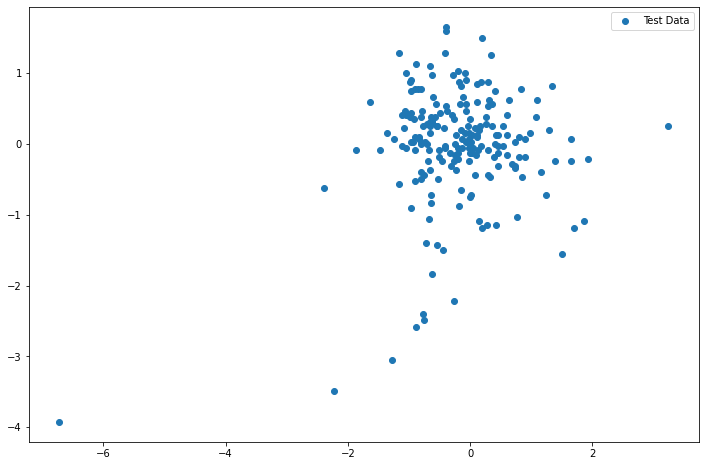

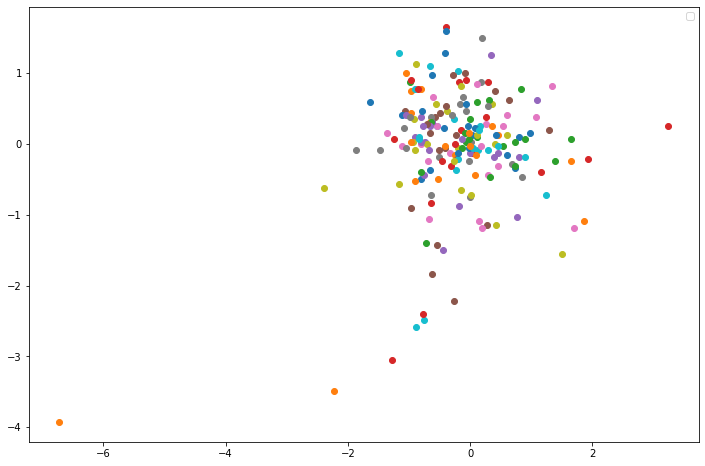

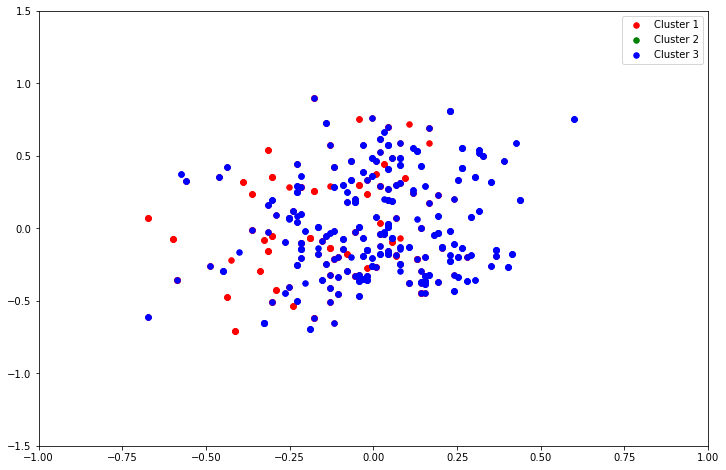

In [11]:
def main():
    knn(3)
    kmeans()


if __name__ == "__main__":
    main()